In [1]:
%load_ext jupyter_black

# 13. The Zoo of Linear Models


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_sparse_coded_signal
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV

from sklearn.metrics import mean_squared_error, r2_score

In [3]:
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_X = diabetes_X[:, np.newaxis, 6]

## Regularization Norms

**Ordinaly Least Squares (OLS).** A vanilla linear regression. Solved in O(Nn^2) (via LU or LL*)

**Ridge Regression a.k.a. Tickhonov Regularization.** $L_2$ regularization norm.  Solved in O(Nn^2).

**Least Absolute Shrinkage and Selection Operator(LASSO) Regression** a.k.a. **Sparse Regression**. $L_1$ regularization norm. Optimized by gradient methods.

**ElasticNet** aka **mixed norm regularization.** Convex combination of $L_1$ and $L_2$ regularization terms.


## Constrained parameter set

### Non-negative OLS

Бывает такое (особенно часто - в инализе масс-спектрограмм или в обратных задачах в физике), что мы точно знаем, что отрицательных коэффициентов не бывает.

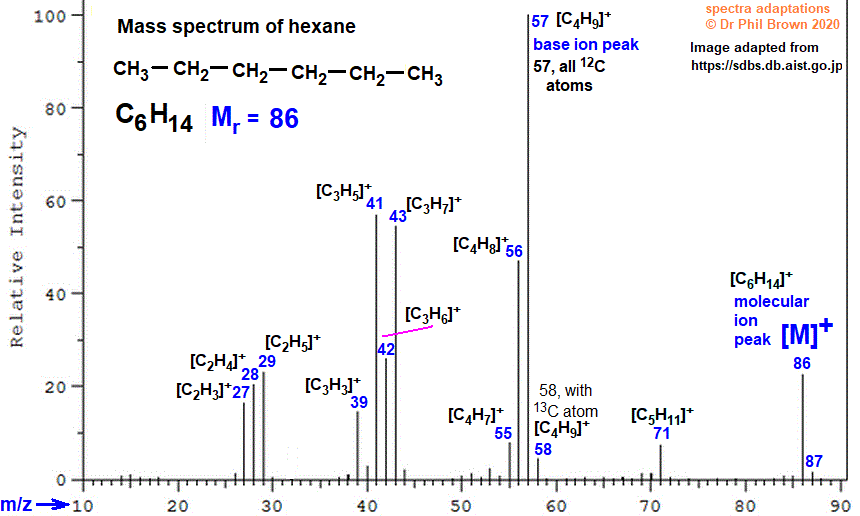

Интересно, что эта задача сводится к OLS (как?), поэтому оптимизация по сути такая же, как в обычной линейной регрессии.


Coefficients: 
 -647.3466141356599 153.0336939672656
Mean squared error common: mean_squared_error(diabetes_y_test, diabetes_y_pred)


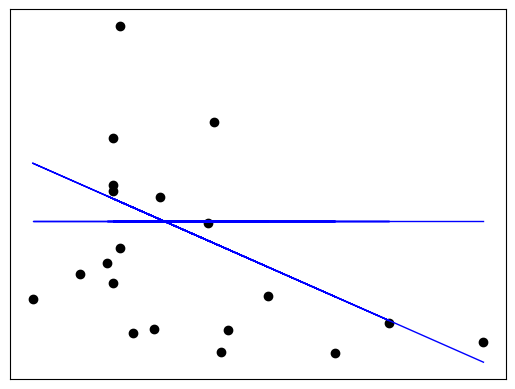

In [4]:
# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = LinearRegression()
regr_nnls = LinearRegression(positive=True)

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)
regr_nnls.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)
diabetes_y_pred_nnls = regr_nnls.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_[0], regr.intercept_)

# The mean squared error
print("Mean squared error common: mean_squared_error(diabetes_y_test, diabetes_y_pred)")

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=1)
plt.plot(diabetes_X_test, diabetes_y_pred_nnls, color="blue", linewidth=1)
plt.xticks(())
plt.yticks(())
plt.show()

Какая у такой модели вероятностная интерпретация? 

Как вы думаете, как такое обучать?

### Orthogonal Mathcing Pursuit

![](https://upload.wikimedia.org/wikipedia/commons/3/38/Orthogonal_Matching_Pursuit.gif)

В обработке сигналов стандартная ситуация, когда число фичей сравнимо с числом точек данных, причем многие фичи сильно скореллированы.
Условно, мы хотим восстановить какой-то сигнал по данным. Для этого возьмем огромное количество базисных функций (например, [wavelet](https://en.wikipedia.org/wiki/Wavelet)'ов или любое другое семейство [ортогональных функций](https://ru.wikipedia.org/wiki/%D0%A0%D1%8F%D0%B4_%D0%A4%D1%83%D1%80%D1%8C%D0%B5#%D0%A2%D1%80%D0%B8%D0%B3%D0%BE%D0%BD%D0%BE%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D1%80%D1%8F%D0%B4_%D0%A4%D1%83%D1%80%D1%8C%D0%B5), и вычислим в каждой точке из данных.

Алгоритм: найти фичу, которая сильнее всего коррелирует с таргетом, добавить в список разрешенных фичей, обучить OLS, вычесть из таргета предсказания нашей модели, повторить. 

In [22]:
n_components, n_features = 512, 100
n_nonzero_coefs = 17

# generate the data
y, X, w = make_sparse_coded_signal(
    n_samples=1,
    n_components=n_components,
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    random_state=0,
)
X = X.T
(idx,) = w.nonzero()
X.shape, y.shape, w.shape

((100, 512), (100,), (512,))

0.0


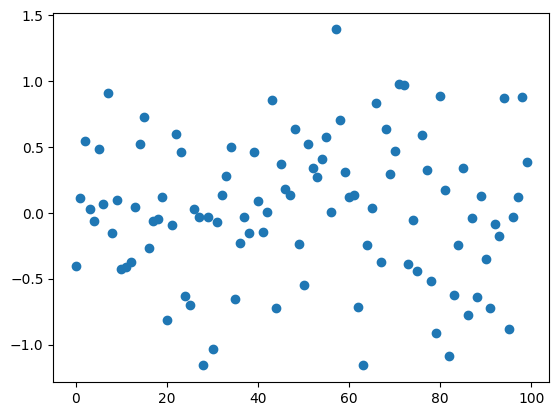

In [28]:
print(((X @ w - y) ** 2).sum())
plt.scatter(np.arange(len(y)), y)

In [6]:
# distort the clean signal
y_noisy = y + 0.05 * np.random.randn(len(y))

<StemContainer object of 3 artists>

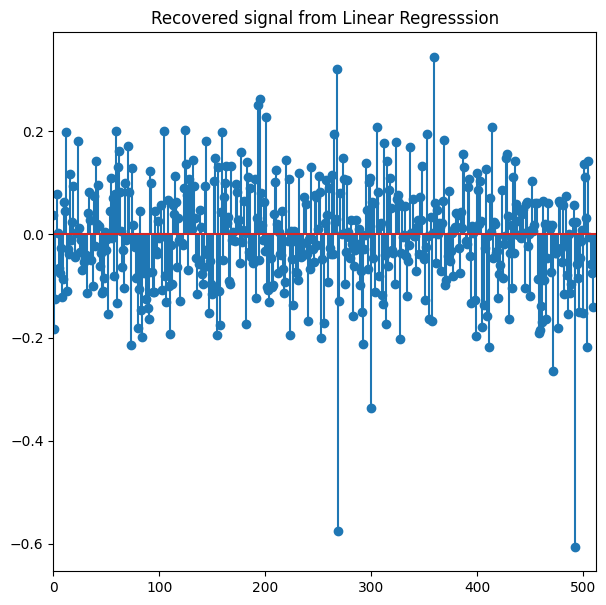

In [7]:
# plot the noise-free reconstruction
ols = LinearRegression()
ols.fit(X, y)
coef = ols.coef_
(idx_r,) = coef.nonzero()
plt.figure(figsize=(7, 7))
# plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from Linear Regresssion")
plt.stem(idx_r, coef[idx_r])

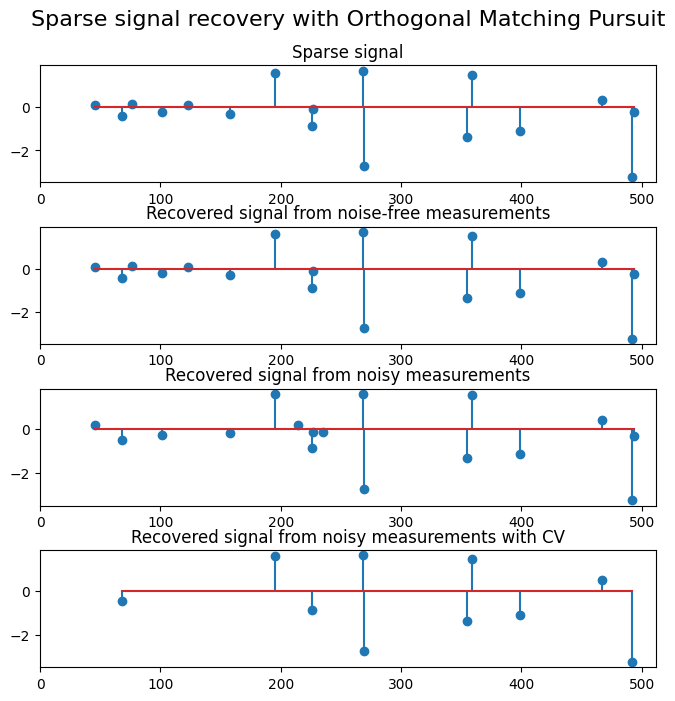

In [8]:
# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(4, 1, 1)
plt.xlim(0, 512)
plt.title("Sparse signal")
plt.stem(idx, w[idx])

# plot the noise-free reconstruction
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(X, y)
coef = omp.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r])

# plot the noisy reconstruction
omp.fit(X, y_noisy)
coef = omp.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 3)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements")
plt.stem(idx_r, coef[idx_r])

# plot the noisy reconstruction with number of non-zeros set by CV
omp_cv = OrthogonalMatchingPursuitCV()
omp_cv.fit(X, y_noisy)
coef = omp_cv.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 4)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements with CV")
plt.stem(idx_r, coef[idx_r])

plt.subplots_adjust(0.06, 0.04, 0.94, 0.90, 0.20, 0.38)
plt.suptitle("Sparse signal recovery with Orthogonal Matching Pursuit", fontsize=16)
plt.show()

# Robust Regression
  

OLS чувствительна к выбросам, поэтому...

* Random Sample Consensus Regression (RANSAC): обучить модель на случайном подмножестве, поделить точки на inliers и outliers, обучить на inliers, повторить. Ответ -- множество, максимизирующее число inlierэов. **Что может пойти не так при слишком маленьком пороге на inlierов?**
* Huber: use a loss which grows quadratically with distance, and then switches to linear $$
L_\delta (r) = \begin{cases}
 \frac{1}{2}{r^2}                   & \text{for } |r| \le \delta, \\
 \delta \cdot \left(|r| - \frac{1}{2}\delta\right), & \text{otherwise.}
\end{cases}
$$
![](https://upload.wikimedia.org/wikipedia/commons/c/cc/Huber_loss.svg)
* TheilSen: обучить `n_subsamples` раз OLS на подномжествах, усреднить веса.

----

* RANSAC is good for strong outliers in the y direction

* TheilSen is good for small outliers, both in direction X and y, but has a break point above which it performs worse than OLS.

* The scores of HuberRegressor may not be compared directly to both TheilSen and RANSAC because it does not attempt to completely filter the outliers but lessen their effect.


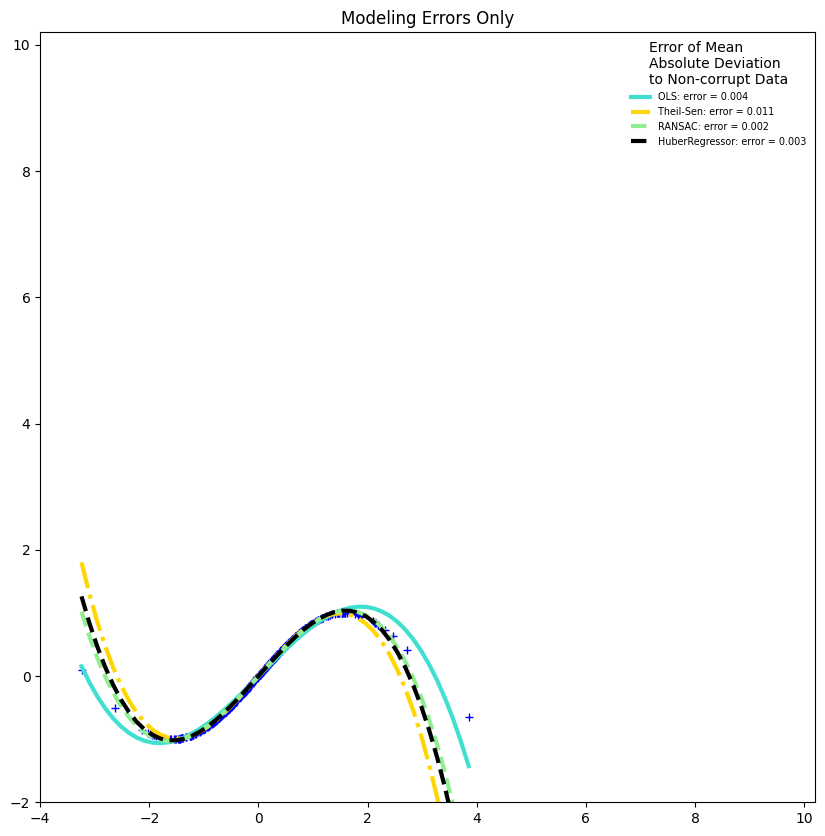

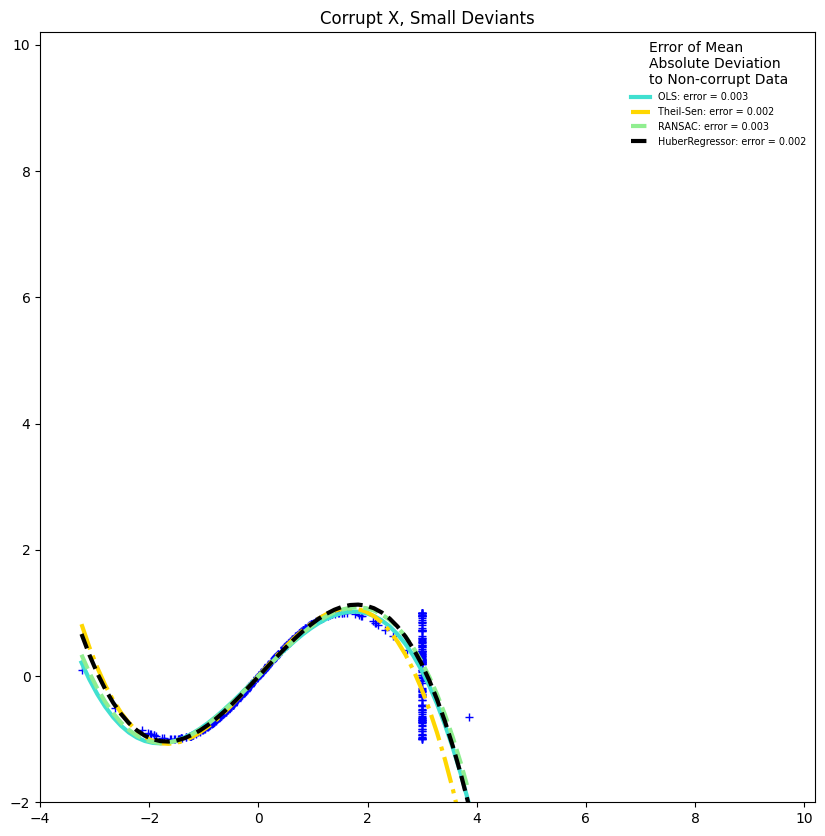

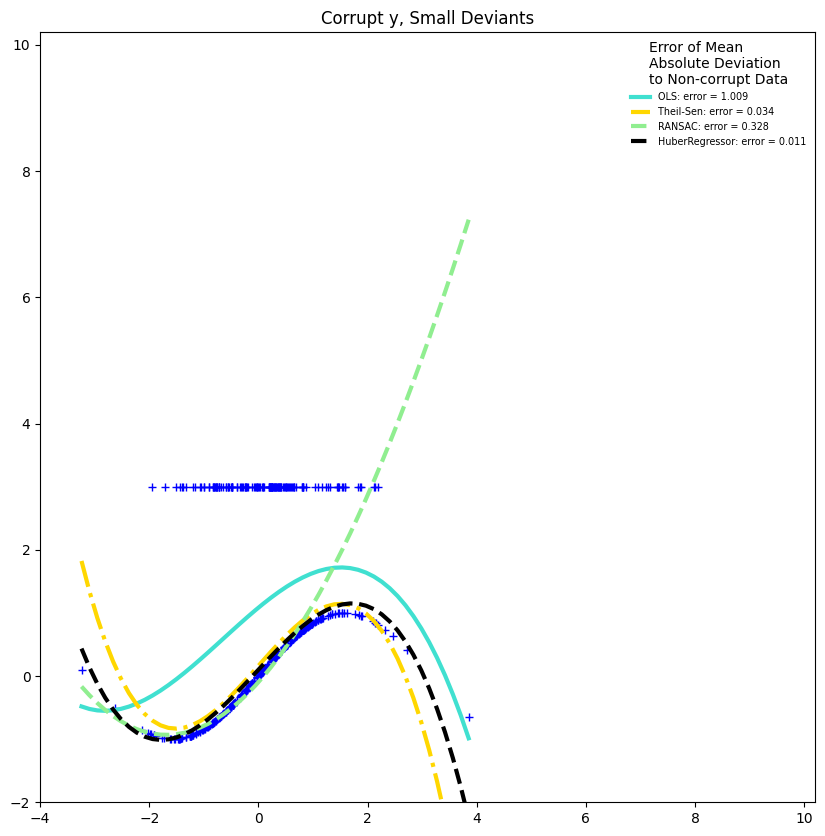

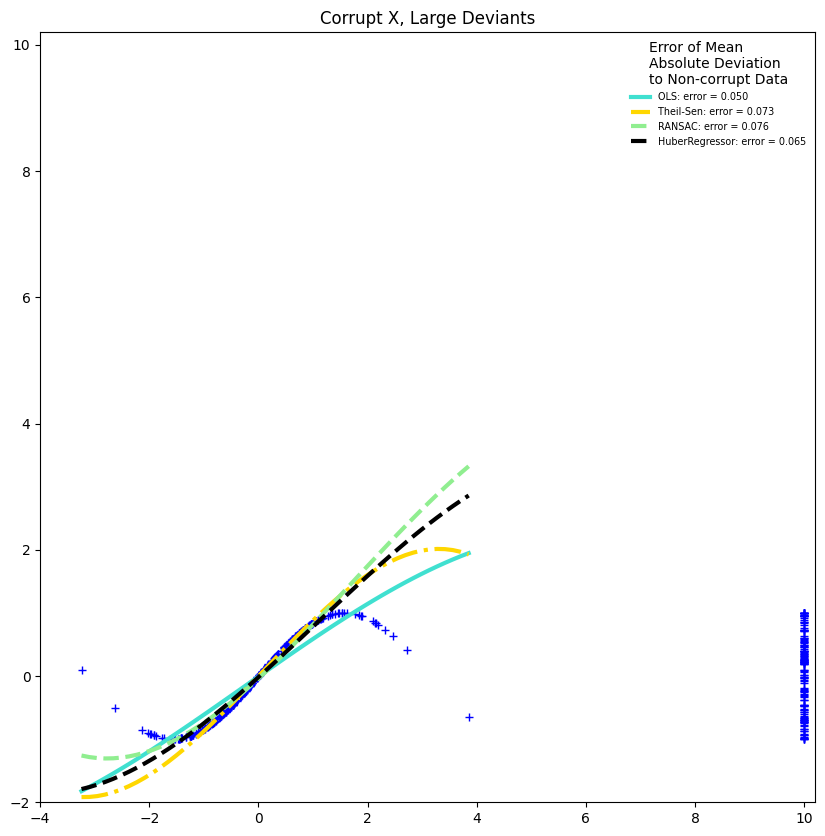

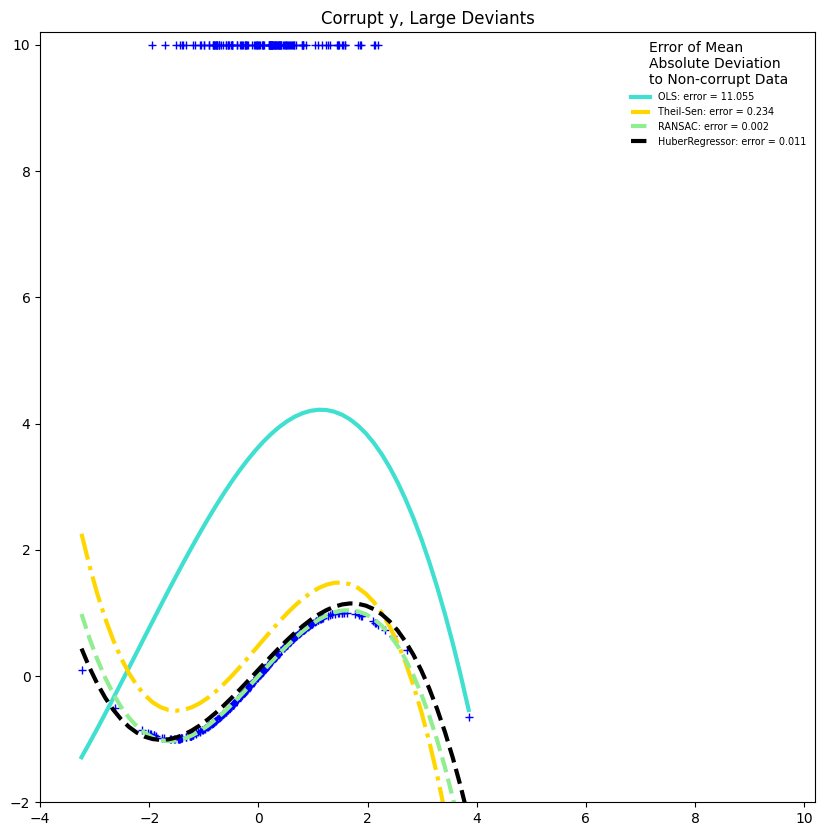

In [10]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(42)

X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X[:, np.newaxis]

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

estimators = [
    ("OLS", LinearRegression()),
    ("Theil-Sen", TheilSenRegressor(random_state=42)),
    ("RANSAC", RANSACRegressor(random_state=42)),
    ("HuberRegressor", HuberRegressor()),
]
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "HuberRegressor": "black",
}
linestyle = {"OLS": "-", "Theil-Sen": "-.", "RANSAC": "--", "HuberRegressor": "--"}
lw = 3

x_plot = np.linspace(X.min(), X.max())
for title, this_X, this_y in [
    ("Modeling Errors Only", X, y),
    ("Corrupt X, Small Deviants", X_errors, y),
    ("Corrupt y, Small Deviants", X, y_errors),
    ("Corrupt X, Large Deviants", X_errors_large, y),
    ("Corrupt y, Large Deviants", X, y_errors_large),
]:
    plt.figure(figsize=(10, 10))
    plt.plot(this_X[:, 0], this_y, "b+")

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(
            x_plot,
            y_plot,
            color=colors[name],
            linestyle=linestyle[name],
            linewidth=lw,
            label="%s: error = %.3f" % (name, mse),
        )

    legend_title = "Error of Mean\nAbsolute Deviation\nto Non-corrupt Data"
    legend = plt.legend(
        loc="upper right", frameon=False, title=legend_title, prop=dict(size="x-small")
    )
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)
plt.show()

# Orthogonal Distance Regression

Помните задачу со звездочкой про восстановление эллипса? Там были не совсем честные точки, шум семплировался только вдоль оси y. С помощью этой модели, можно будет восстановить эллипс по данным с честным шумом во всех направлениях.

![](https://media.geeksforgeeks.org/wp-content/uploads/20211219223720/19121.png)

OLS - предполагает что фичи такие, какие они есть, а таргеты - измерены с нормально распределенной ошибкой. Но на самом то деле, мы фичи тоже измерям с какой-то ошибкой, почему бы не попробовать поискать прямую, честные расстояния до имеюзщихся точек? 

Какое вероятнотсное предположение будет соответсвовать такой модели?

### Задача со звездочкой 11: NNLS.
Напишите свою Non-Negative-Least-Squares на numpy **(scipy.optimize нельзя)**.

Подробно прокомментируйте, почему ваш алгоритм работает.

### Задача со звездочкой 12: ODR.
Откройте [ODRPACK User Guide](https://docs.scipy.org/doc/external/odrpack_guide.pdf) (осторожно: FORTRAN-77), и разберитесь что происходит в этом примере, поищите более современные данные и воспроизведите.

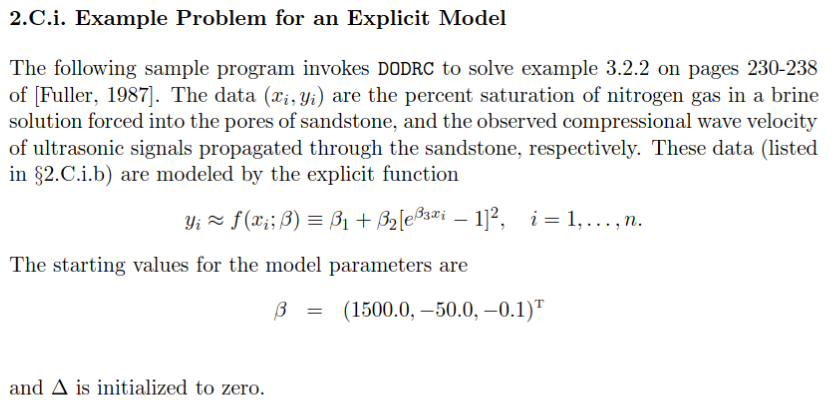